# Triangle counting via sparse linear algebra

This example considers different ways to count triangles in a graph. It illustrates some of the constructs available in Intrepydd, although for this particular problem, a pure Numpy/Scipy version is likely faster in the sequential case. (On a multicore system, an Intrepydd implementation may be faster or more scalable.)

## Background: Counting triangles in a social network

A social network may be modeled as an undirected graph, like the one shown below.

![An example of an undirected graph](http://cse6040.gatech.edu/datasets/graph-triangles-example.png)

The _nodes_ (or _vertices_) of this graph, shown as numbered circles, might represent people, and the _edges_ (or links connecting them) might represent who is friends with whom. In this case, person 0 is friends with all the "odd birds" of this network, persons 1, 3, and 5, but has no direct connection to persons 2 and 4.

One type of analysis one might perform on such a graph is _counting triangles_, that is, the number of relationships of the form $a$ knows $b$, $b$ knows $c$, and $c$ knows $a$. In the graph shown above, there are two such triangles: (0, 1, 3) and (0, 3, 5).

**A conventional graph-based approach.** A commonly used Python-based library for graph computations is [NetworkX](https://networkx.github.io/). While it turns out to be much slower than the method described in this notebook, if you are interested in seeing how to use NetworkX, see our [supplemental notebook](./tricount-networkx.ipynb).

## A matrix-based method for counting triangles

**Adjacency matrix.** Let $A$ be the _adjacency matrix_ representation of the graph, defined as follows. The entries of $A$ are either 0 or 1; and $a_{i,j}$ equals 1 if and only if there is an edge connecting nodes $i$ and $j$. For instance, for the graph shown above,

$$
A = \begin{bmatrix}
        0 & 1 & 0 & 1 & 0 & 1 \\
        1 & 0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 & 0 \\
        1 & 1 & 1 & 0 & 1 & 1 \\
        0 & 0 & 0 & 1 & 0 & 0 \\
        1 & 0 & 0 & 1 & 0 & 0
    \end{bmatrix}.
$$

Observe that the relationships are symmetric. For instance, 0 and 1 are mutually connected; therefore, both $a_{0,1}$ and $a_{1, 0}$ equal 1, and in general, $A = A^T$.

In [1]:
import numpy

A = numpy.array([[0, 1, 0, 1, 0, 1],
                 [1, 0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0, 0],
                 [1, 1, 1, 0, 1, 1],
                 [0, 0, 0, 1, 0, 0],
                 [1, 0, 0, 1, 0, 0]])
A

array([[0, 1, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [1, 1, 1, 0, 1, 1],
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0]])

**Matrix-based graph analysis via linear algebra.** Given such a matrix-based representation of a graph, here is one way to count triangles using linear algebra operations.

First, let $A \cdot B$ denote matrix multiplication. That is, $C = A \cdot B$ means $c_{i,j} = \sum_k a_{i,k} b_{k, j}$.

Next, let $A \odot B$ denote _elementwise_ multiplication. That is, $E = A \odot B$ means $e_{i, j} = a_{i, j} b_{i, j}$.

Then, here is a two-step method to compute the number of triangles, which we'll denote as $t(A)$:

$$
\begin{eqnarray}
       C & = & (A \cdot A) \odot A \\
    t(A) & = & \frac{1}{6} \sum_{i, j} c_{i,j}.
\end{eqnarray}
$$

The first step computes a "count" matrix $C$. Each element, $c_{i,j}$, counts the number of triangles in which both $i$ and $j$ appear. You can see this fact algebraically; the scalar formula for $c_{i,j}$ is given by

$$
    c_{i,j} = \underbrace{\sum_k a_{i,k} \cdot a_{k, j}}_{A \cdot A} \cdot \underbrace{a_{i,j}}_{\odot A}
$$

Observe that the summand involves the product $a_{i,k} a_{k, j} a_{i,j}$, which is nonzero only if all of the $(i,k)$, $(k,j)$, and $(i,j)$ edges exist.

For the example shown above, $c_{0, 1} = c_{1,0} = 1$ since there is only one triangle that uses the edge $(0, 1)$, whereas $c_{0, 3} = c_{3, 0} = 2$ because the edge $(0, 3)$ appears in two triangles.

The second step sums all the elements of $C$. However, the sum alone will overcount the number of unique triangles by a factor of six (6), hence the additional factor of $\frac{1}{6}$. (Why?)

> Instead of summing all the entries of $A$, one can exploit symmetry and consider just the upper- or lower-triangle, which is a good additional optimization you might try once you've finished the main exercises contained herein.

The function, **`count_triangles(A, ret_C)`**, below, implements the above formula. That is, given a symmetric Numpy array `A` representing the adjacency matrix of a graph, this function will return the number of triangles. It assumes the input matrix `A` is a (dense!) Numpy array.

The `ret_C` flag is a boolean, and when `True`, the function returns **both** the triangle count **and** the matrix $C$; otherwise, it returns just the triangle count.

In [2]:
def count_triangles(A, ret_C=False):
    assert (type(A) is numpy.ndarray) and (A.ndim == 2) and (A.shape[0] == A.shape[1])
    C = (A @ A) * A
    n_tri = C.sum() // 6
    if ret_C:
        return n_tri, C
    return n_tri

print(count_triangles(A, ret_C=True))

(2, array([[0, 1, 0, 2, 0, 1],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [2, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0]]))


The following cell does some extensive testing based on random sparse graphs.

0 16 16.0
1 20 18.0
2 30 22.0
3 23 22.25
4 14 20.6
5 19 20.333333333333332
6 22 20.571428571428573
7 33 22.125
8 27 22.666666666666668
9 25 22.9
10 32 23.727272727272727
11 23 23.666666666666668
12 14 22.923076923076923
13 16 22.428571428571427
14 24 22.533333333333335
15 20 22.375
16 29 22.764705882352942
17 23 22.77777777777778
18 24 22.842105263157894
19 19 22.65
20 22 22.61904761904762
21 24 22.681818181818183
22 17 22.434782608695652
23 22 22.416666666666668
24 20 22.32

==> The statistics on triangle counts for random sparse graphs are consistent with expectations!


/Users/richie/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


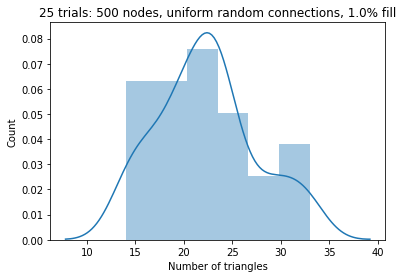

In [3]:
# Test cell: `count_triangles_test2`

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def check_count_triangles_large(n, den=1e-2):
    U_large = numpy.triu(numpy.random.rand(n, n) <= den).astype(int)
    numpy.fill_diagonal(U_large, 0)
    A_large = U_large + U_large.T
    return count_triangles(A_large)

n, den, k_max, mu, sd = 500, 1e-2, 25, 21, 5
nts = numpy.zeros(k_max, dtype=int)
for k in range(k_max):
    nts[k] = check_count_triangles_large(n, den)
    print(k, nts[k], numpy.sum(nts[:k+1])/(k+1))
sns.distplot(nts)
plt.xlabel("Number of triangles")
plt.ylabel("Count")
plt.title("{} trials: {} nodes, uniform random connections, {}% fill".format(k_max, n, den*100))

assert (mu-sd) <= numpy.mean(nts) <= (mu+sd), \
       f"mean={numpy.mean(nts)}: The statistics on triangle counts for random graphs do not match expectations."

print("\n==> The statistics on triangle counts for random sparse graphs are consistent with expectations!")

## The IMDB actor network dataset

Later, we will apply the matrix-based triangle counting method to a real "social" network, namely, the graph of actors who have appeared in the same movie. That is, let each actor be a node in the graph, with an edge between two actor nodes $i$ and $j$ if they appeared in the same movie together. If there are $n$ actors, then this graph can be represented by an $n \times n$ adjacency matrix, where $a_{i,j}=1$ if and only if $i$ and $j$ appeared in at least one movie together, and 0 otherwise. (We will only allow 0 or 1 values in the matrix, effectively ignoring the number of movies in which the actors "co-occurred.)

The dataset in this problem uses data collected on a crawl of the [Top 250 movies on the Internet Movie Database](https://github.com/napsternxg/IMDB-Graph/tree/master/Data/tutorial/tutorial) (circa 2012). If you are interested in the raw data to construct the sparse matrix corresponding to the graph, refer to the [NetworkX-based supplemental notebook](./tricount-networks.ipynb).

In [4]:
import pickle
import scipy

with open('imdb_tricounts.pickle', 'rb') as fp:
    ntri_nx = pickle.load(fp)
with open('imdb_tricounts_matrix.pickle', 'rb') as fp:
    tricounts_nx = pickle.load(fp)
with open('imdb_actors.pickle', 'rb') as fp:
    V_actors = pickle.load(fp)
A_casts = scipy.sparse.load_npz('imdb_matrix.npz')
A_casts

<12975x12975 sparse matrix of type '<class 'numpy.int64'>'
	with 1246812 stored elements in Compressed Sparse Row format>

**Observation: sparsity.** The matrix of actor co-occurrences is quite sparse. There are $12,975$ actors, which means as many as $\approx 12,\!975^2 / 2 \approx 84$ million possible co-occurences; yet, the matrix (`A_casts`) only appears to have $1.2$ million nonzeros, which is about $600,\!000$ observed co-occurrences, or less than 1% of the possible co-occurrences.

## A sparse matrix-based approach

The first matrix-based example we gave above stores the graph as a _dense_ matrix. However, as noted above, the graph itself is actually quite sparse. Thus, any method that scales like $\mathcal{O}(n^2)$ or worse, where $n$ is the number of actors, will be much slower than a method that exploits sparsity.

Luckily, Numpy/Scipy has built-in support for sparse matrices and basic operations on them. Therefore, we can use the simple implementation below to implement the counting formula, and trust that Numpy/Scipy works reasonably well if the input matrix is sparse.

In [5]:
# Triangle counter for a *sparse* adjacency matrix
def count_triangles_spmat__baseline(A, ret_C=False): # We'll try to speed this up using Intrepydd later
    C = (A @ A).multiply(A)
    n_tri = C.sum() // 6
    if ret_C:
        return n_tri, C
    return n_tri

ntri_spmat, C_spmat = count_triangles_spmat__baseline(A_casts, ret_C=True)
print(f"Found ~ {ntri_spmat*1e-6:.1f} million triangles")

Found ~ 24.6 million triangles


In [6]:
# Test the results by building `tricounts` as described above and comparing it to NetworkX's result.
def spmat_to_tricounts(C):
    tricounts_ind = C.dot(numpy.ones(len(V_actors), dtype=int)) // 2
    tricounts = {actor: count for actor, count in zip(V_actors, tricounts_ind)}
    return tricounts

def test_spmat(tricounts_spmat, tricounts_nx):
    for actor in tricounts_nx:
        assert tricounts_nx[actor] == tricounts_spmat[actor], \
               "For actor '{}', NetworkX saw {} triangles whereas you saw {}.".format(actors[actor]
                                                                                      , tricounts_nx[actor]
                                                                                      , tricounts[actor])
    return True

tricounts = spmat_to_tricounts(C_spmat)
test_spmat(tricounts, tricounts_nx)
print("Passed!")

Passed!


In [7]:
# Lastly, let's see if the matrix approach yields any speedup...

t_spmat = %timeit -o count_triangles_spmat__baseline(A_casts)
print(f"\n==> Execution time: ~ {t_spmat.average*1e3:.1f} ms")

560 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

==> Execution time: ~ 560.5 ms


**Observation.** In experiments we have done on conventional desktop machines, this sparse matrix-based implementation is 10-30x faster than a NetworkX-based implementation.

## An Intrepydd version: Domain-specific wrappers

The linear algebraic algorithm has a "straightforward" translation to Intrepydd's domain-specific wrappers. In this example, the `calc_C()` Intrepydd kernel defined below implements the Numpy/Scipy statement, `C = (A @ A).multiply(A)`, where `A` and `C` are sparse matrices. In the current version of Intrepydd, sparse matrix operations are wrappers for the [CombBLAS](https://people.eecs.berkeley.edu/~aydin/CombBLAS/html/) library.

Take a moment to read this implementation, and observe the following.
- In the current version of Intrepydd, it is not possible to pass full sparse matrix objects between Python and Intrepydd. One workaround is to "extract" the underlying arrays representing the sparse matrix and pass those instead. Here, we assume the input `A` and the output `C` are [compressed sparse row (CSR) matrices](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html), which are represented by an array of floating-point values, integer column indices, and an integer array of row pointers.
- Sparse matrices in Intrepydd, at present, must store the values as floating-point. By contrast, the array `A_casts` constructed above has only integer values. That will require the caller to do an extra conversion, which might affect execution time.
- The Intrepydd call `csr_to_spm()` translates from these CSR arrays to an Intrepydd sparse matrix object. Refer to the [Intrepydd Guide function list](https://hpcgarage.github.io/intrepyddguide/library/functions.html) for additional details.
- Given an Intrepydd sparse matrix object `A`, the Intrepydd call `spmm(A, A)` corresponds to `A @ A` in Numpy/Scipy.
- The Intrepydd call `spm_mul(A, B)` corresponds to `A.multiply(B)`.
- The Intrepydd call `spm_to_csr()` translates from an Intrepydd sparse matrix object back to an array representation for the caller. These are passed-by-reference arguments, which the caller of `calc_C` must supply. (See the modified Python function, `count_triangles_spmat__pydd()`, a couple code cells below.) Furthermore, this operation might also affect overall execution time, just as `csr_to_spm()` can.

In [8]:
%%writefile tricount_pydd.pydd

def calc_C(a_vals: Array(float64), a_inds: Array(int32), a_ptrs: Array(int32), a_nc: int32,
           c_vals: Array(float64), c_inds: Array(int32), c_ptrs: Array(int32)):
    A = csr_to_spm(a_vals, a_inds, a_ptrs, a_nc)
    C = spm_mul(spmm(A, A), A)
    spm_to_csr(C, c_vals, c_inds, c_ptrs)

Overwriting tricount_pydd.pydd


In [9]:
!pyddc tricount_pydd.pydd

The above defined the Intrepydd kernel; here is how it may be called from a Python driver function (`count_triangles_spmat__pydd`). Pay particular attention to how one gets the array representation for a Numpy/Scipy CSR object, and how one can construct the output.

> Regarding the output, this implementation exploits the fact that for `C = A.multiply(A @ A)`, `C` must have the _same_ sparsity pattern as `A`. (Can you see why?) Therefore, when the driver allocates space for `C` (`c_vals`, `c_inds`, and `c_ptrs`), it is sufficient for these to have the same sizes as those for `A`.

In [10]:
import tricount_pydd

def count_triangles_spmat__pydd(A, ret_C=False):
    a_vals, a_inds, a_ptrs, a_nc = A.data.astype(float), A.indices, A.indptr, numpy.int32(A.shape[1])
    c_vals = numpy.empty(len(a_vals), numpy.float64)
    c_inds = numpy.empty(len(a_inds), numpy.int32)
    c_ptrs = numpy.empty(len(a_ptrs), numpy.int32)
    tricount_pydd.calc_C(a_vals, a_inds, a_ptrs, a_nc, c_vals, c_inds, c_ptrs)
    n_tri = int(c_vals.sum()) // 6
    if ret_C:
        from scipy.sparse import csr_matrix
        C = csr_matrix((c_vals, c_inds, c_ptrs), shape=A.shape)
        return n_tri, C
    return n_tri

ntri_pydd, C_pydd = count_triangles_spmat__pydd(A_casts, ret_C=True)
print(f"Found ~ {ntri_pydd*1e-6:.1f} million triangles")

Found ~ 24.6 million triangles


In [11]:
# Correctness check:
tricounts_pydd = spmat_to_tricounts(C_pydd)
test_spmat(tricounts_pydd, tricounts_nx)
print("Passed!")

Passed!


In [12]:
t_pydd = %timeit -o count_triangles_spmat__pydd(A_casts)
print(f"\n==> Execution time: ~ {t_pydd.average*1e3:.1f} ms")

958 ms ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

==> Execution time: ~ 957.9 ms


**Observation.** The time is a little bit slower than the pure Numpy/Scipy version. Again, as noted previously, there are extra overheads in the current version of Intrepydd for input/output data transfers due to `csr_to_spm()` and `spm_to_csr()` calls.

## Another Intrepydd version: "lowering" the implementation

The current version of Intrepydd is translated into C++ and then compiled. So, you can also try to write "low-level" implementations that look like what you might have written in C++, and hope to get C++-level performance from it. The following implementation is an example of "lowering" the original implementation.

In this case, lowering makes it possible to optimize _across_ function calls. That is, recall the linear algebraic  operation that triangle counting expresses, written here in a slightly different and more suggestive way (since $A \odot B = B \odot A$):

$$
    c_{i,j} = \underbrace{a_{i,j} \, \cdot}_{A \odot} \underbrace{\sum_k a_{i,k} \cdot a_{k, j}}_{A \cdot A}.
$$

In this form, it should be clear that $C$ only has a nonzero output $c_{i,j}$ when $A$ has a nonzero element $a_{i,j}$. Therefore, rather than compute the entire product $B = A \cdot A$ first, we can compute only those $b_{i,j}$ where $a_{i,j} \neq 0$. The computation of a single $b_{i,j}$ is a _sparse dot product_ between a sparse row $i$ of $A$ and a sparse column $j$ of $A$. And since $A$ is symmetric ($A = A^T$), sparse rows and columns are "interchangeable."

Of course, it is not clear if such an implementation will be faster or not because there are many ways to implement $A \cdot A$ to save computation and data movement, but from the point of view of learning Intrepydd, it is instructive to try.

> _Aside._ This formula also explains why one expects $C$ to have the same sparsity pattern as $A$, as noted previously.

In addition, lowering confers one more potential benefit in this case. Recall that Intrepydd sparse matrix objects must store their values in floating-point; by contrast, if we lower and do not use the sparse interface at all, we can change the implementation to use integer types, too.

> _Logical operations._ At present, logical operations (`or`, `and`, `not`) are not supported in Intrepydd. Therefore, the sparse dot product code cannot use the more compact, `has_nzs_left = (ki < ni) and (kj < nj)`.

In [13]:
%%writefile tricount_pydd_lowered.pydd

def sparse_dot_rows_ij(a_vals: Array(int32), a_inds: Array(int32), a_ptrs: Array(int32),
                       i: int32, j: int32) -> int32:
    # Assumes column indices are sorted within each row
    ki = a_ptrs[i]   # type: int32
    ni = a_ptrs[i+1] # type: int32
    kj = a_ptrs[j]   # type: int32
    nj = a_ptrs[j+1] # type: int32
    s = 0
    has_nzs_left = 1
    if ki >= ni: has_nzs_left = 0
    if kj >= nj: has_nzs_left = 0
    while has_nzs_left:
        if a_inds[ki] < a_inds[kj]:
            ki += 1
        elif a_inds[ki] > a_inds[kj]:
            kj += 1
        else:
            s += a_vals[ki] * a_vals[kj]
            ki += 1
            kj += 1
        if ki >= ni: has_nzs_left = 0
        if kj >= nj: has_nzs_left = 0
    return s

def calc_C(n: int32,
           a_vals: Array(int32), a_inds: Array(int32), a_ptrs: Array(int32),
           c_vals: Array(int32), c_inds: Array(int32), c_ptrs: Array(int32)):
    for i in range(n):
        for k in range(a_ptrs[i], a_ptrs[i+1]):
            j = a_inds[k]
            a_ij = a_vals[k]
            c_vals[k] = a_ij * sparse_dot_rows_ij(a_vals, a_inds, a_ptrs, i, j)

Overwriting tricount_pydd_lowered.pydd


In [14]:
!pyddc tricount_pydd_lowered.pydd

In [15]:
import tricount_pydd_lowered

def count_triangles_spmat__pydd2(A, ret_C=False):
    assert A.shape[0] == A.shape[1]
    n = A.shape[0]
    a_vals, a_inds, a_ptrs = A.data.astype(numpy.int32), A.indices, A.indptr
    c_vals = a_vals.copy()
    c_inds = a_inds.copy()
    c_ptrs = a_ptrs.copy()
    tricount_pydd_lowered.calc_C(n,
                                 a_vals, a_inds, a_ptrs,
                                 c_vals, c_inds, c_ptrs)
    n_tri = c_vals.sum() // 6
    if ret_C:
        from scipy.sparse import csr_matrix
        C = csr_matrix((c_vals, c_inds, c_ptrs), shape=A.shape)
        return n_tri, C
    return n_tri

ntri_pydd2, C_pydd2 = count_triangles_spmat__pydd2(A_casts, ret_C=True)
print(f"Found ~ {ntri_pydd2*1e-6:.1f} million triangles")

Found ~ 24.6 million triangles


In [16]:
# Correctness check:
tricounts_pydd2 = spmat_to_tricounts(C_pydd2)
test_spmat(tricounts_pydd2, tricounts_nx)
print("Passed!")

Passed!


In [17]:
t_pydd2 = %timeit -o count_triangles_spmat__pydd2(A_casts)
print(f"\n==> Execution time: ~ {t_pydd2.average*1e3:.1f} ms")

7.3 s ± 578 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

==> Execution time: ~ 7303.5 ms


**Observation.** This Intrepydd version is not faster than the earlier Intrepydd version or the native Numpy/Scipy versions. However, having a lowered version means you can try even more optimizations, including parallelization! (All the other versions have been purely sequential.)

**Fin!** We hope this notebook has been a useful tutorial of how to use Intrepydd's sparse matrix operations, in the context of implementing graph algorithms that exploits the duality between a sparse matrix and a sparse graph. In particular, if you are working on a graph analysis problem, you might consider whether there is a matrix version and try to implement that using the APIs and techniques described above.